# 基于多学科排名的全球高校聚类分析


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
# 读取所有学科数据文件
csv_dir = Path('csv')
csv_files = sorted([f for f in csv_dir.glob('*.csv') if f.name != '0-ALL.csv'])

print(f"共找到 {len(csv_files)} 个学科文件")

共找到 22 个学科文件


## 构建排名特征张量

为每个机构构建特征向量：每个学科的排名


In [3]:
institution_features = {} # 存储所有机构的特征
subject_max_ranks = {} # 存储每个学科的最大排名（机构总数）

for csv_file in csv_files:
    subject = csv_file.stem.split('-', 1)[1]
    # 跳过第一行
    df = pd.read_csv(csv_file, skiprows=1, encoding='latin1')
    df.columns = df.columns.str.strip()
    # 获取有效机构
    df_valid = df[df['Institutions'].notna()].copy()
    df_valid = df_valid[~df_valid['Institutions'].str.contains('Copyright|Clarivate', na=False)]
    # 该学科的机构总数（即最大排名）
    max_rank = len(df_valid)
    subject_max_ranks[subject] = max_rank
    # 记录每个机构在该学科的排名
    for rank, (_, row) in enumerate(df_valid.iterrows(), start=1):
        institution = row['Institutions']
        if institution not in institution_features:
            institution_features[institution] = {}
        institution_features[institution][subject] = rank
        
print('共有 {} 所机构'.format(len(institution_features)))
print('共有 {} 个学科'.format(len(subject_max_ranks)))


共有 9990 所机构
共有 22 个学科


In [4]:
# 转换为DataFrame
df_features = pd.DataFrame(institution_features).T

# 对未入榜的学科，填入该学科的最大排名 * 2
for subject in subject_max_ranks:
    if subject in df_features.columns:
        fill_value = int(subject_max_ranks[subject] * 2)
        df_features[subject] = df_features[subject].fillna(fill_value)

# 确保所有特征列为整数类型
df_features = df_features.astype(int)

# 确保列顺序一致
df_features = df_features[sorted(df_features.columns)]

print('特征张量形状: {}'.format(df_features.shape))
print('{} 所机构'.format(df_features.shape[0]))
print('{} 个学科特征'.format(df_features.shape[1]))

df_features

特征张量形状: (9990, 22)
9990 所机构
22 个学科特征


,Agricultural Sciences,Biology & Biochemistry,Chemistry,Clinical Medicine,Computer Science,Economics & Business,Engineering,Environment Ecology,Geosciences,Immunology,...,Microbiology,Molecular Biology & Genetics,Multidisciplinary,Neuroscience & Behavior,Pharmacology & Toxicology,Physics,Plant & Animal Science,Psychiatry Psychology,"Social Sciences, General",Space Science
CHINESE ACADEMY OF SCIENCES,1,3,1,188,1,60,1,1,1,36,...,3,13,3,71,4,1,1,173,47,15
CHINESE ACADEMY OF AGRICULTURAL SCIENCES,2,175,357,4360,826,1086,570,107,541,666,...,28,243,205,2596,388,1990,6,2294,1920,472
UNITED STATES DEPARTMENT OF AGRICULTURE (USDA),3,179,756,1476,738,1086,899,14,138,546,...,29,248,145,2596,650,1990,4,2294,435,472
CHINA AGRICULTURAL UNIVERSITY,4,215,398,3470,273,1086,314,112,520,660,...,95,358,432,2596,518,1990,16,2294,767,472
INRAE,5,54,348,696,591,320,521,13,126,316,...,17,183,166,669,270,1990,5,2294,367,472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"METEOROLOGICAL OBSERVATION CENTER, CHINA METEOROLOGICAL ADMINISTRATION",2762,3298,4282,13508,1726,1086,5574,4132,1168,2354,...,1606,2338,432,2596,2778,1990,3900,2294,4814,472
FED INST GEOSCI & NAT RESOURCES BGR,2762,3298,4282,13508,1726,1086,5574,4132,1169,2354,...,1606,2338,432,2596,2778,1990,3900,2294,4814,472
SWEDISH INST SPACE PHYS,2762,3298,4282,13508,1726,1086,5574,4132,1171,2354,...,1606,2338,432,2596,2778,1990,3900,2294,4814,472
NATIONAL REMOTE SENSING CENTRE (NRSC),2762,3298,4282,13508,1726,1086,5574,4132,1173,2354,...,1606,2338,432,2596,2778,1990,3900,2294,4814,472


## K-means聚类, k = 5


In [5]:
# 对特征数据进行标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features.values)

# 聚类
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

df_features['cluster'] = clusters

# 统计各簇数量
print('各簇高校数量:')
for i in range(optimal_k):
    count = (clusters == i).sum()
    print(f'  簇 {i}: {count} 所高校')

# 查找华东师范大学
institution_name = "EAST CHINA NORMAL UNIVERSITY"
ecnu_names = [name for name in df_features.index if institution_name == name.upper()]
ecnu_name = ecnu_names[0]
ecnu_cluster = df_features.loc[ecnu_name, 'cluster']
print(f'\n{ecnu_name}: ')
print(f'所属簇: {int(ecnu_cluster)}')


各簇高校数量:
  簇 0: 5100 所高校
  簇 1: 417 所高校
  簇 2: 792 所高校
  簇 3: 3198 所高校
  簇 4: 483 所高校

EAST CHINA NORMAL UNIVERSITY: 
所属簇: 1


## 聚类可视化（PCA降维）


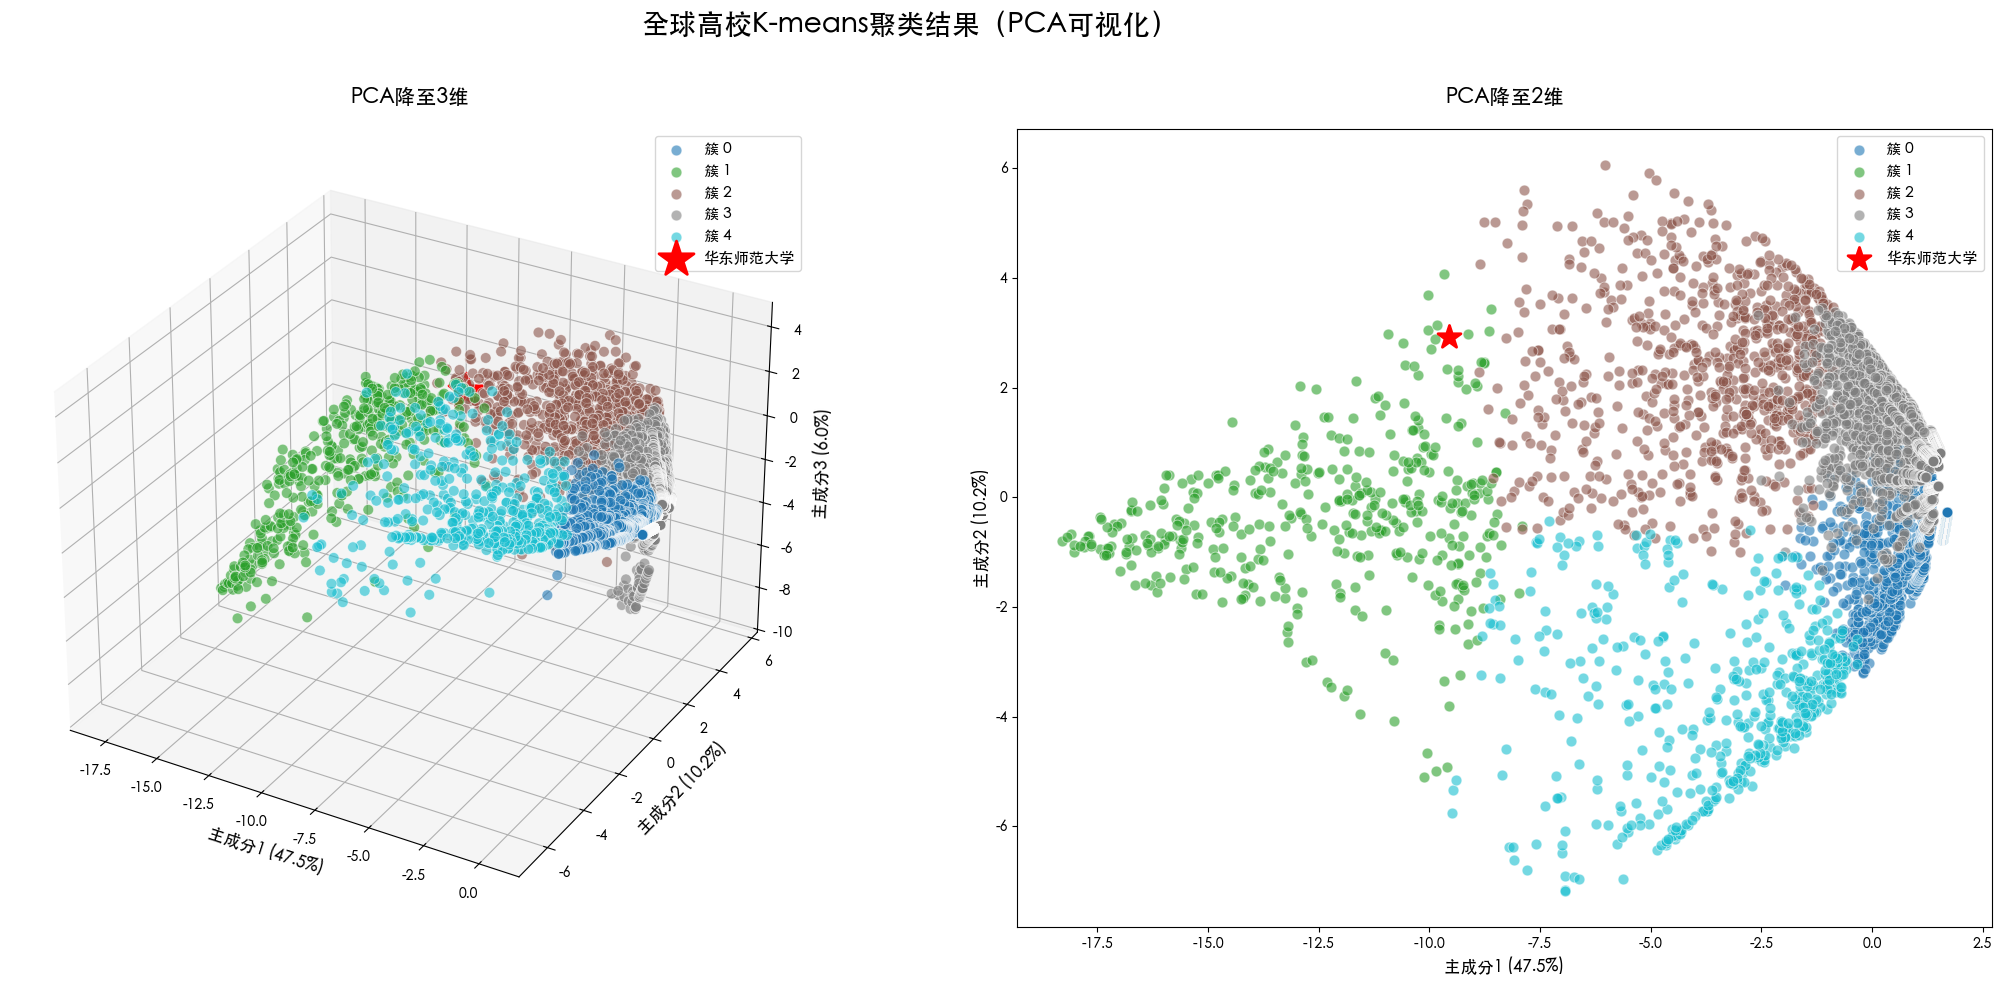

In [6]:
# PCA可视化：分别降维至3维和2维，用subplot左右并排显示，且3D坐标轴自适应范围

plt.rcParams['font.sans-serif'] = ['Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

# PCA降维
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

fig = plt.figure(figsize=(22, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])

# ---- 3D subplot ----
ax3d = fig.add_subplot(gs[0], projection='3d')
for i in range(optimal_k):
    mask = clusters == i
    ax3d.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2], 
                 c=[colors[i]], label='簇 {}'.format(i), alpha=0.6, s=60,
                 edgecolors='white', linewidth=0.6)

# 标注华东师范大学
if ecnu_name:
    ecnu_idx = df_features.index.get_loc(ecnu_name)
    ax3d.scatter(X_pca_3d[ecnu_idx, 0], X_pca_3d[ecnu_idx, 1], X_pca_3d[ecnu_idx, 2],
                 c='red', s=700, marker='*', linewidths=2,
                 label='华东师范大学', zorder=1000)

ax3d.set_xlabel('主成分1 ({:.1%})'.format(pca_3d.explained_variance_ratio_[0]), fontsize=12)
ax3d.set_ylabel('主成分2 ({:.1%})'.format(pca_3d.explained_variance_ratio_[1]), fontsize=12)
ax3d.set_zlabel('主成分3 ({:.1%})'.format(pca_3d.explained_variance_ratio_[2]), fontsize=12)
ax3d.set_title('PCA降至3维', fontsize=15, pad=18)
ax3d.legend(loc='best', fontsize=11)

# 坐标轴自适应
for dim in range(3):
    min_val = X_pca_3d[:, dim].min() * 1.05 if X_pca_3d[:, dim].min() < 0 else X_pca_3d[:, dim].min() * 0.95
    max_val = X_pca_3d[:, dim].max() * 1.05 if X_pca_3d[:, dim].max() > 0 else X_pca_3d[:, dim].max() * 0.95
    if dim == 0:
        ax3d.set_xlim(min_val, max_val)
    elif dim == 1:
        ax3d.set_ylim(min_val, max_val)
    else:
        ax3d.set_zlim(min_val, max_val)

# ---- 2D subplot ----
ax2d = fig.add_subplot(gs[1])
for i in range(optimal_k):
    mask = clusters == i
    ax2d.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
                 c=[colors[i]], label='簇 {}'.format(i), alpha=0.6, s=60,
                 edgecolors='white', linewidth=0.6)

# 标注华东师范大学
if ecnu_name:
    ecnu_idx = df_features.index.get_loc(ecnu_name)
    ax2d.scatter(X_pca_2d[ecnu_idx, 0], X_pca_2d[ecnu_idx, 1],
                 c='red', s=300, marker='*', linewidths=2,
                 label='华东师范大学', zorder=1000)

ax2d.set_xlabel('主成分1 ({:.1%})'.format(pca_2d.explained_variance_ratio_[0]), fontsize=12)
ax2d.set_ylabel('主成分2 ({:.1%})'.format(pca_2d.explained_variance_ratio_[1]), fontsize=12)
ax2d.set_title('PCA降至2维', fontsize=15, pad=18)
ax2d.legend(loc='best', fontsize=11)

fig.suptitle('全球高校K-means聚类结果（PCA可视化）', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 各簇特征分析


In [7]:
# 分析各簇特征
cluster_analysis = []

for i in range(optimal_k):
    cluster_schools = df_features[df_features['cluster'] == i]
    cluster_data = cluster_schools.drop('cluster', axis=1)
    
    # 计算入榜学科数
    subjects_entered = []
    for school_idx, school_row in cluster_data.iterrows():
        count = 0
        for subject in cluster_data.columns:
            if subject in subject_max_ranks:
                if school_row[subject] <= subject_max_ranks[subject]:
                    count += 1
        subjects_entered.append(count)
    avg_subjects = np.mean(subjects_entered)
    
    # 计算入榜学科的平均排名
    all_ranks = []
    for subject in cluster_data.columns:
        if subject in subject_max_ranks:
            ranks = cluster_data[subject][cluster_data[subject] <= subject_max_ranks[subject]]
            all_ranks.extend(ranks.values)
    avg_rank = np.mean(all_ranks) if all_ranks else 0
    
    # 最小排名（最好的排名）
    min_rank = cluster_data.min().min()
    
    cluster_analysis.append({
        '簇': i,
        '高校数': len(cluster_schools),
        '平均入榜学科数': '{:.1f}'.format(avg_subjects),
        '入榜学科平均排名': '{:.0f}'.format(avg_rank),
        '最佳排名': '{:.0f}'.format(min_rank)
    })

df_cluster_analysis = pd.DataFrame(cluster_analysis)
display(df_cluster_analysis)


,簇,高校数,平均入榜学科数,入榜学科平均排名,最佳排名
0,0,5100,1.5,3032,1
1,1,417,19.3,373,1
2,2,792,9.7,985,4
3,3,3198,2.1,1368,3
4,4,483,8.8,771,5


In [8]:
# 为每个簇推断类型
cluster_types = {}
for i in range(optimal_k):
    cluster_schools = df_features[df_features['cluster'] == i]
    cluster_data = cluster_schools.drop('cluster', axis=1)
    
    # 计算平均入榜学科数
    subjects_entered = []
    for school_idx, school_row in cluster_data.iterrows():
        count = sum(1 for subject in cluster_data.columns 
                   if subject in subject_max_ranks and school_row[subject] <= subject_max_ranks[subject])
        subjects_entered.append(count)
    avg_subjects = np.mean(subjects_entered)
    
    # 计算入榜学科的平均排名
    all_ranks = []
    for subject in cluster_data.columns:
        if subject in subject_max_ranks:
            ranks = cluster_data[subject][cluster_data[subject] <= subject_max_ranks[subject]]
            all_ranks.extend(ranks.values)
    avg_rank = np.mean(all_ranks) if all_ranks else 1000
    
    # ------ 标准 -------
    if avg_subjects > 15 and avg_rank < 300:
        cluster_type = '顶尖综合型大学'
    elif avg_subjects > 10 and avg_rank < 500:
        cluster_type = '优秀综合型大学'
    elif avg_subjects < 5:
        if avg_rank < 1500:
            cluster_type = '精专特色型大学'
        else:
            cluster_type = '新兴特色型大学'
    elif avg_rank > 800:
        cluster_type = '基础发展型大学'
    else:
        cluster_type = '稳健综合型大学'
    
    cluster_types[i] = cluster_type

print('\n各簇类型推断:')
for i, ctype in cluster_types.items():
    print('  簇 {}: {}'.format(i, ctype))



各簇类型推断:
  簇 0: 新兴特色型大学
  簇 1: 优秀综合型大学
  簇 2: 基础发展型大学
  簇 3: 精专特色型大学
  簇 4: 稳健综合型大学


## 与华东师范大学相似的高校


In [9]:
# 同簇高校
same_cluster = df_features[df_features['cluster'] == ecnu_cluster].drop('cluster', axis=1)

# 计算欧氏距离
ecnu_features = same_cluster.loc[ecnu_name].values.reshape(1, -1)
ecnu_scaled = scaler.transform(-ecnu_features)

distances = {}
for school in same_cluster.index:
    if school != ecnu_name:
        school_features = same_cluster.loc[school].values.reshape(1, -1)
        school_scaled = scaler.transform(-school_features)
        dist = np.linalg.norm(ecnu_scaled - school_scaled)
        distances[school] = dist

# 最相似的n所高校
n = 5
similar_schools = sorted(distances.items(), key=lambda x: x[1])[:n]

print(f'\n与华东师范大学最相似的{n}所高校（簇 {ecnu_cluster} - {cluster_types[int(ecnu_cluster)]}）:\n')
for rank, (school, dist) in enumerate(similar_schools, 1):
    school_data = same_cluster.loc[school]
    # 计算入榜学科数
    subject_count = sum(1 for subject in same_cluster.columns 
                        if subject in subject_max_ranks and school_data[subject] <= subject_max_ranks[subject])
    print(f'{rank}. {school}')
    print(f'相似度距离: {dist:.3f}')  # 归一化后的欧式距离
    


与华东师范大学最相似的5所高校（簇 1 - 优秀综合型大学）:

1. UNIVERSITY OF BASQUE COUNTRY
相似度距离: 2.596
2. UNIVERSITY OF ELECTRONIC SCIENCE & TECHNOLOGY OF CHINA
相似度距离: 3.077
3. SOUTHWEST UNIVERSITY - CHINA
相似度距离: 3.635
4. UNIVERSITY OF MILANO-BICOCCA
相似度距离: 4.250
5. SOUTHEAST UNIVERSITY - CHINA
相似度距离: 4.348
